In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, SGD
from keras.metrics import MAE,MAPE,mean_squared_error,mean_absolute_percentage_error
from keras.losses import MAE,MAPE,mean_squared_error,mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
import time

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


In [2]:
import matplotlib.pyplot as plt

In [3]:
filename = "alber.csv"
df = pd.read_csv(filename, header=0, usecols=["IN","OUT","INQ","FILE","ADJ","FP","EFFORT"])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 7 columns):
IN        24 non-null int64
OUT       24 non-null int64
INQ       24 non-null int64
FILE      24 non-null int64
ADJ       24 non-null float64
FP        24 non-null int64
EFFORT    24 non-null float64
dtypes: float64(2), int64(5)
memory usage: 1.4 KB


In [5]:
df.describe()

,IN,OUT,INQ,FILE,ADJ,FP,EFFORT
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,40.250000,47.250000,16.875000,17.375000,0.989583,647.625000,21.875000
std,36.913824,35.169466,19.337534,15.522249,0.135116,487.995261,28.417895
min,7.000000,12.000000,0.000000,3.000000,0.750000,199.000000,0.500000
25%,23.000000,18.500000,3.250000,5.750000,0.887500,287.500000,7.150000
50%,33.500000,39.000000,13.500000,11.500000,1.000000,506.000000,11.450000
75%,43.500000,64.500000,20.250000,22.250000,1.100000,710.250000,19.525000
max,193.000000,150.000000,75.000000,60.000000,1.200000,1902.000000,105.200000


In [6]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)
print(df)
print(scaled_data)

     IN  OUT  INQ  FILE   ADJ    FP  EFFORT
0    25  150   75    60  1.00  1750   102.4
1   193   98   70    36  1.00  1902   105.2
2    70   27    0    12  0.80   428    11.1
3    40   60   20    12  1.15   759    21.1
4    10   69    1     9  0.90   431    28.8
5    13   19    0    23  0.75   283    10.0
6    34   14    0     5  0.80   205     8.0
7    17   17   15     5  1.10   289     4.9
8    45   64   14    16  0.95   680    12.9
9    40   60   20    15  1.15   794    19.0
10   41   27   29     5  1.10   512    10.8
11   33   17    8     5  0.75   224     2.9
12   28   41   16    11  0.85   417     7.5
13   43   40   20    35  0.85   682    12.0
14    7   12   13     8  0.95   209     4.1
15   28   38   24     9  1.05   512    15.8
16   42   57   12     5  1.10   606    18.3
17   27   20   24     6  1.10   400     8.9
18   48   66   13    50  1.15  1235    38.1
19   69  112   21    39  1.20  1572    61.2
20   25   28    4    22  1.05   500     3.6
21   61   68    0    11  1.00   

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [7]:
def k10Fold(nfolds,data):
    isOdd = False
    efsize = len(data)//nfolds
    if len(data)-efsize*nfolds:
        isOdd = True
    folds = []
    foldscounter = 0
    counter = 0
    curfold = []
    i = 0
    for item in data:
        if foldscounter < 25:
            if counter < efsize :
                curfold.append(i)
                counter += 1
            else:
                foldscounter+=1
                if foldscounter != 24:
                    folds.append(curfold)
                    
                    curfold = []
                    curfold.append(i)
                    counter = 1
            i+=1
        else:
            curfold.append(i)
            i+=1
    folds.append(curfold)
    print(folds)
    return folds

In [8]:
def trainTestSpliter(testFolIndex,data):
    test_data = []
    train_data = []
    for i in range(len(data)):
        if i not in testFolIndex:
            train_data.append(data[i])
        else:
            test_data.append(data[i])
    return np.array(train_data), np.array(test_data)

In [9]:
def dataTargetSpluter(train_d,test_d):
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    for i in train_d:
        train_x.append(i[:len(i)])
        train_y.append(i[len(i)-1])
    for i in test_d:
        test_x.append(i[:len(i)])
        test_y.append(i[len(i)-1])
    return np.array(train_x), np.array(train_y), np.array(test_x), np.array(test_y)

In [10]:
foldsIndex = k10Fold(24,scaled_data)

[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23]]


In [11]:
model = Sequential()
model.add(Dense((128), activation="tanh", input_shape=(7,)))
model.add(Dense((64), activation="tanh"))
model.add(Dense((32), activation="tanh"))
model.add(Dense((1), activation="sigmoid"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 11,393
Trainable params: 11,393
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(loss="mean_squared_error", optimizer="Adam", metrics=["mae","mape"])

training using 24 folds: each model has 200 epochs
 
Fold  # 1


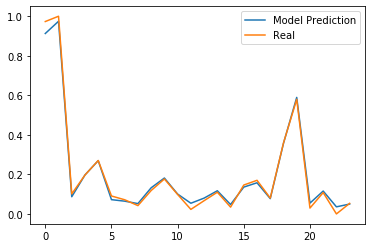

predicted =  [0.91268337]        real =  0.973256924546323       
predicted =  [0.97451764]        real =  1.0       
predicted =  [0.08693603]        real =  0.10124164278892073       
predicted =  [0.19721508]        real =  0.1967526265520535       
predicted =  [0.26949206]        real =  0.2702960840496657       
predicted =  [0.07214822]        real =  0.09073543457497614       
predicted =  [0.06449727]        real =  0.07163323782234958       
predicted =  [0.05223318]        real =  0.04202483285577842       
predicted =  [0.13217771]        real =  0.11843361986628465       
predicted =  [0.18155685]        real =  0.1766953199617956       
predicted =  [0.10043752]        real =  0.09837631327602676       
predicted =  [0.05401863]        real =  0.022922636103151865       
predicted =  [0.07994466]        real =  0.06685768863419295       
predicted =  [0.11711945]        real =  0.10983763132760269       
predicted =  [0.04752966]        real =  0.03438395415472779       


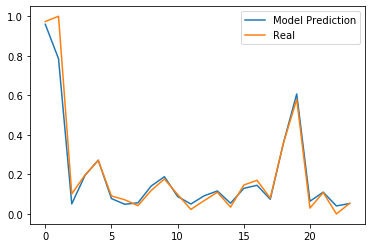

predicted =  [0.95932966]        real =  0.973256924546323       
predicted =  [0.78495455]        real =  1.0       
predicted =  [0.0506733]        real =  0.10124164278892073       
predicted =  [0.19473754]        real =  0.1967526265520535       
predicted =  [0.27213052]        real =  0.2702960840496657       
predicted =  [0.07758815]        real =  0.09073543457497614       
predicted =  [0.04889463]        real =  0.07163323782234958       
predicted =  [0.05604009]        real =  0.04202483285577842       
predicted =  [0.14090943]        real =  0.11843361986628465       
predicted =  [0.18819004]        real =  0.1766953199617956       
predicted =  [0.08812216]        real =  0.09837631327602676       
predicted =  [0.04994751]        real =  0.022922636103151865       
predicted =  [0.09147324]        real =  0.06685768863419295       
predicted =  [0.11612856]        real =  0.10983763132760269       
predicted =  [0.05406537]        real =  0.03438395415472779       
p

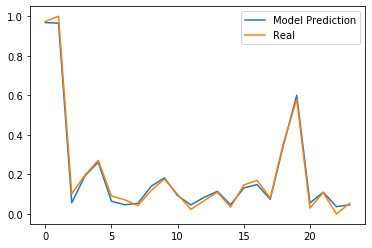

predicted =  [0.9679901]        real =  0.973256924546323       
predicted =  [0.9650145]        real =  1.0       
predicted =  [0.05661751]        real =  0.10124164278892073       
predicted =  [0.19290423]        real =  0.1967526265520535       
predicted =  [0.26161987]        real =  0.2702960840496657       
predicted =  [0.06405318]        real =  0.09073543457497614       
predicted =  [0.04619081]        real =  0.07163323782234958       
predicted =  [0.05355393]        real =  0.04202483285577842       
predicted =  [0.13967204]        real =  0.11843361986628465       
predicted =  [0.18266548]        real =  0.1766953199617956       
predicted =  [0.09225561]        real =  0.09837631327602676       
predicted =  [0.0453573]        real =  0.022922636103151865       
predicted =  [0.08369229]        real =  0.06685768863419295       
predicted =  [0.11396032]        real =  0.10983763132760269       
predicted =  [0.04629267]        real =  0.03438395415472779       
pre

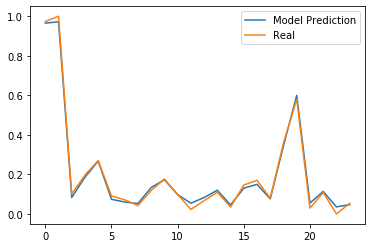

predicted =  [0.96517557]        real =  0.973256924546323       
predicted =  [0.9717119]        real =  1.0       
predicted =  [0.08359887]        real =  0.10124164278892073       
predicted =  [0.18593553]        real =  0.1967526265520535       
predicted =  [0.26742807]        real =  0.2702960840496657       
predicted =  [0.07392725]        real =  0.09073543457497614       
predicted =  [0.06038947]        real =  0.07163323782234958       
predicted =  [0.05239661]        real =  0.04202483285577842       
predicted =  [0.13345364]        real =  0.11843361986628465       
predicted =  [0.17285687]        real =  0.1766953199617956       
predicted =  [0.09774338]        real =  0.09837631327602676       
predicted =  [0.05410253]        real =  0.022922636103151865       
predicted =  [0.08299181]        real =  0.06685768863419295       
predicted =  [0.11976329]        real =  0.10983763132760269       
predicted =  [0.04533298]        real =  0.03438395415472779       
p

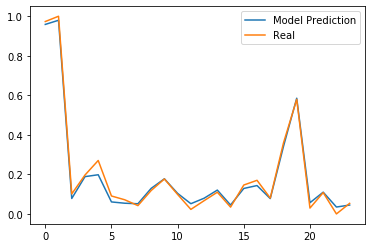

predicted =  [0.95868874]        real =  0.973256924546323       
predicted =  [0.9795914]        real =  1.0       
predicted =  [0.07813188]        real =  0.10124164278892073       
predicted =  [0.18863545]        real =  0.1967526265520535       
predicted =  [0.19815786]        real =  0.2702960840496657       
predicted =  [0.06063135]        real =  0.09073543457497614       
predicted =  [0.05411172]        real =  0.07163323782234958       
predicted =  [0.05147175]        real =  0.04202483285577842       
predicted =  [0.12919617]        real =  0.11843361986628465       
predicted =  [0.17762744]        real =  0.1766953199617956       
predicted =  [0.10378511]        real =  0.09837631327602676       
predicted =  [0.05168403]        real =  0.022922636103151865       
predicted =  [0.07932287]        real =  0.06685768863419295       
predicted =  [0.12053543]        real =  0.10983763132760269       
predicted =  [0.04503122]        real =  0.03438395415472779       
p

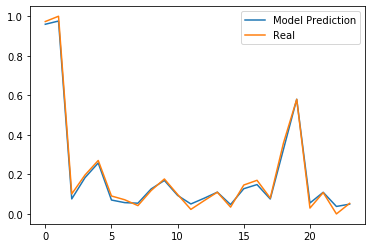

predicted =  [0.9594857]        real =  0.973256924546323       
predicted =  [0.97572476]        real =  1.0       
predicted =  [0.07594621]        real =  0.10124164278892073       
predicted =  [0.18330412]        real =  0.1967526265520535       
predicted =  [0.25776157]        real =  0.2702960840496657       
predicted =  [0.07023679]        real =  0.09073543457497614       
predicted =  [0.05706303]        real =  0.07163323782234958       
predicted =  [0.05423516]        real =  0.04202483285577842       
predicted =  [0.12645476]        real =  0.11843361986628465       
predicted =  [0.16924904]        real =  0.1766953199617956       
predicted =  [0.09358287]        real =  0.09837631327602676       
predicted =  [0.05033737]        real =  0.022922636103151865       
predicted =  [0.07914933]        real =  0.06685768863419295       
predicted =  [0.11004612]        real =  0.10983763132760269       
predicted =  [0.04726788]        real =  0.03438395415472779       
p

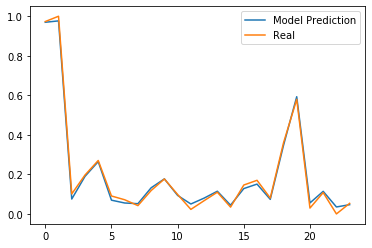

predicted =  [0.9695491]        real =  0.973256924546323       
predicted =  [0.9765246]        real =  1.0       
predicted =  [0.07529134]        real =  0.10124164278892073       
predicted =  [0.18990627]        real =  0.1967526265520535       
predicted =  [0.26451483]        real =  0.2702960840496657       
predicted =  [0.0695143]        real =  0.09073543457497614       
predicted =  [0.05524276]        real =  0.07163323782234958       
predicted =  [0.05179122]        real =  0.04202483285577842       
predicted =  [0.13224849]        real =  0.11843361986628465       
predicted =  [0.17715213]        real =  0.1766953199617956       
predicted =  [0.09357654]        real =  0.09837631327602676       
predicted =  [0.05019912]        real =  0.022922636103151865       
predicted =  [0.07987605]        real =  0.06685768863419295       
predicted =  [0.11479632]        real =  0.10983763132760269       
predicted =  [0.04421656]        real =  0.03438395415472779       
pre

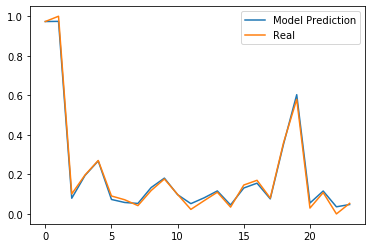

predicted =  [0.9732593]        real =  0.973256924546323       
predicted =  [0.97408944]        real =  1.0       
predicted =  [0.07933376]        real =  0.10124164278892073       
predicted =  [0.19446374]        real =  0.1967526265520535       
predicted =  [0.26809746]        real =  0.2702960840496657       
predicted =  [0.07311881]        real =  0.09073543457497614       
predicted =  [0.05784419]        real =  0.07163323782234958       
predicted =  [0.05301675]        real =  0.04202483285577842       
predicted =  [0.13346285]        real =  0.11843361986628465       
predicted =  [0.18104044]        real =  0.1766953199617956       
predicted =  [0.09732994]        real =  0.09837631327602676       
predicted =  [0.05195591]        real =  0.022922636103151865       
predicted =  [0.08132756]        real =  0.06685768863419295       
predicted =  [0.11620046]        real =  0.10983763132760269       
predicted =  [0.04528411]        real =  0.03438395415472779       
p

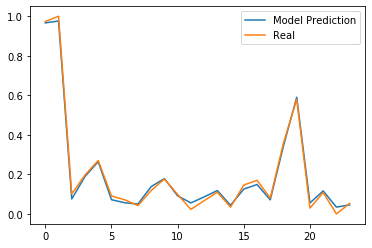

predicted =  [0.96633065]        real =  0.973256924546323       
predicted =  [0.9759536]        real =  1.0       
predicted =  [0.07566516]        real =  0.10124164278892073       
predicted =  [0.18951309]        real =  0.1967526265520535       
predicted =  [0.2640696]        real =  0.2702960840496657       
predicted =  [0.07191452]        real =  0.09073543457497614       
predicted =  [0.05641488]        real =  0.07163323782234958       
predicted =  [0.05005705]        real =  0.04202483285577842       
predicted =  [0.1382935]        real =  0.11843361986628465       
predicted =  [0.1784991]        real =  0.1766953199617956       
predicted =  [0.09156326]        real =  0.09837631327602676       
predicted =  [0.05573856]        real =  0.022922636103151865       
predicted =  [0.08576722]        real =  0.06685768863419295       
predicted =  [0.11829101]        real =  0.10983763132760269       
predicted =  [0.04368268]        real =  0.03438395415472779       
pred

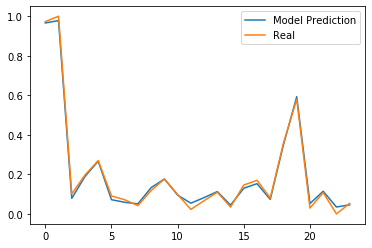

predicted =  [0.9660801]        real =  0.973256924546323       
predicted =  [0.9779816]        real =  1.0       
predicted =  [0.07882237]        real =  0.10124164278892073       
predicted =  [0.1896946]        real =  0.1967526265520535       
predicted =  [0.26653197]        real =  0.2702960840496657       
predicted =  [0.07187372]        real =  0.09073543457497614       
predicted =  [0.05886162]        real =  0.07163323782234958       
predicted =  [0.0510159]        real =  0.04202483285577842       
predicted =  [0.1332455]        real =  0.11843361986628465       
predicted =  [0.17650092]        real =  0.1766953199617956       
predicted =  [0.09512691]        real =  0.09837631327602676       
predicted =  [0.05423561]        real =  0.022922636103151865       
predicted =  [0.08255235]        real =  0.06685768863419295       
predicted =  [0.11305794]        real =  0.10983763132760269       
predicted =  [0.04457514]        real =  0.03438395415472779       
predi

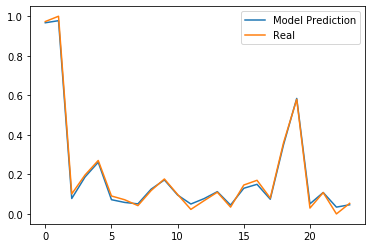

predicted =  [0.96704245]        real =  0.973256924546323       
predicted =  [0.97754014]        real =  1.0       
predicted =  [0.07800752]        real =  0.10124164278892073       
predicted =  [0.18656653]        real =  0.1967526265520535       
predicted =  [0.2613441]        real =  0.2702960840496657       
predicted =  [0.07193124]        real =  0.09073543457497614       
predicted =  [0.05808121]        real =  0.07163323782234958       
predicted =  [0.05086647]        real =  0.04202483285577842       
predicted =  [0.12541005]        real =  0.11843361986628465       
predicted =  [0.17188708]        real =  0.1766953199617956       
predicted =  [0.09549684]        real =  0.09837631327602676       
predicted =  [0.05008974]        real =  0.022922636103151865       
predicted =  [0.07739834]        real =  0.06685768863419295       
predicted =  [0.11255851]        real =  0.10983763132760269       
predicted =  [0.0447527]        real =  0.03438395415472779       
pr

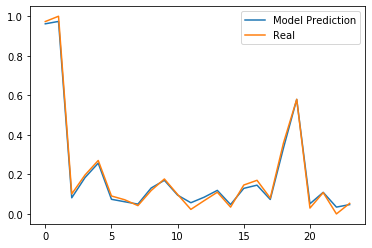

predicted =  [0.9617444]        real =  0.973256924546323       
predicted =  [0.9737988]        real =  1.0       
predicted =  [0.08160827]        real =  0.10124164278892073       
predicted =  [0.18364029]        real =  0.1967526265520535       
predicted =  [0.2568287]        real =  0.2702960840496657       
predicted =  [0.07393892]        real =  0.09073543457497614       
predicted =  [0.06154874]        real =  0.07163323782234958       
predicted =  [0.04957834]        real =  0.04202483285577842       
predicted =  [0.13109155]        real =  0.11843361986628465       
predicted =  [0.16994873]        real =  0.1766953199617956       
predicted =  [0.09493688]        real =  0.09837631327602676       
predicted =  [0.05659337]        real =  0.022922636103151865       
predicted =  [0.08442689]        real =  0.06685768863419295       
predicted =  [0.11905973]        real =  0.10983763132760269       
predicted =  [0.04736267]        real =  0.03438395415472779       
pre

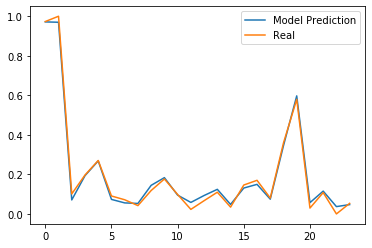

predicted =  [0.9713746]        real =  0.973256924546323       
predicted =  [0.96961087]        real =  1.0       
predicted =  [0.07078569]        real =  0.10124164278892073       
predicted =  [0.1934192]        real =  0.1967526265520535       
predicted =  [0.26825985]        real =  0.2702960840496657       
predicted =  [0.07340807]        real =  0.09073543457497614       
predicted =  [0.05574532]        real =  0.07163323782234958       
predicted =  [0.05294614]        real =  0.04202483285577842       
predicted =  [0.14461139]        real =  0.11843361986628465       
predicted =  [0.18346912]        real =  0.1766953199617956       
predicted =  [0.0950883]        real =  0.09837631327602676       
predicted =  [0.05814422]        real =  0.022922636103151865       
predicted =  [0.09312437]        real =  0.06685768863419295       
predicted =  [0.12437861]        real =  0.10983763132760269       
predicted =  [0.04804696]        real =  0.03438395415472779       
pre

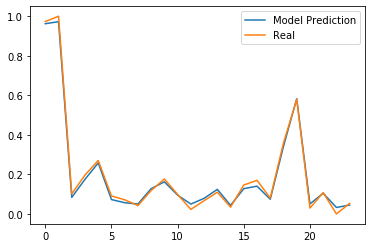

predicted =  [0.96227044]        real =  0.973256924546323       
predicted =  [0.97245544]        real =  1.0       
predicted =  [0.0836383]        real =  0.10124164278892073       
predicted =  [0.17506154]        real =  0.1967526265520535       
predicted =  [0.25798857]        real =  0.2702960840496657       
predicted =  [0.07258544]        real =  0.09073543457497614       
predicted =  [0.05679085]        real =  0.07163323782234958       
predicted =  [0.04994306]        real =  0.04202483285577842       
predicted =  [0.1278838]        real =  0.11843361986628465       
predicted =  [0.16220075]        real =  0.1766953199617956       
predicted =  [0.09503969]        real =  0.09837631327602676       
predicted =  [0.0498144]        real =  0.022922636103151865       
predicted =  [0.07880206]        real =  0.06685768863419295       
predicted =  [0.12419481]        real =  0.10983763132760269       
predicted =  [0.0432511]        real =  0.03438395415472779       
pred

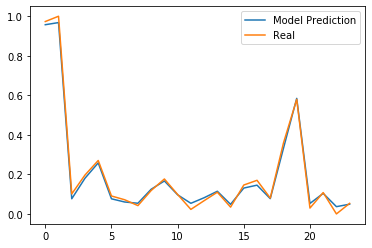

predicted =  [0.95716155]        real =  0.973256924546323       
predicted =  [0.96790487]        real =  1.0       
predicted =  [0.07667091]        real =  0.10124164278892073       
predicted =  [0.18059783]        real =  0.1967526265520535       
predicted =  [0.25819093]        real =  0.2702960840496657       
predicted =  [0.0764233]        real =  0.09073543457497614       
predicted =  [0.0602581]        real =  0.07163323782234958       
predicted =  [0.05399726]        real =  0.04202483285577842       
predicted =  [0.12473407]        real =  0.11843361986628465       
predicted =  [0.16673446]        real =  0.1766953199617956       
predicted =  [0.09674629]        real =  0.09837631327602676       
predicted =  [0.05369655]        real =  0.022922636103151865       
predicted =  [0.08178775]        real =  0.06685768863419295       
predicted =  [0.11463899]        real =  0.10983763132760269       
predicted =  [0.04847695]        real =  0.03438395415472779       
pr

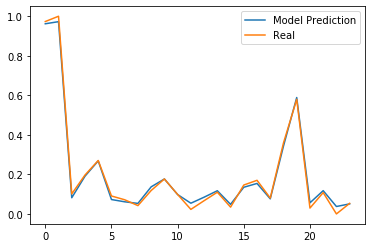

predicted =  [0.96195143]        real =  0.973256924546323       
predicted =  [0.9725742]        real =  1.0       
predicted =  [0.08185953]        real =  0.10124164278892073       
predicted =  [0.19083445]        real =  0.1967526265520535       
predicted =  [0.26828694]        real =  0.2702960840496657       
predicted =  [0.0727246]        real =  0.09073543457497614       
predicted =  [0.06129917]        real =  0.07163323782234958       
predicted =  [0.05323171]        real =  0.04202483285577842       
predicted =  [0.1369657]        real =  0.11843361986628465       
predicted =  [0.17665674]        real =  0.1766953199617956       
predicted =  [0.0979929]        real =  0.09837631327602676       
predicted =  [0.05412386]        real =  0.022922636103151865       
predicted =  [0.08461062]        real =  0.06685768863419295       
predicted =  [0.11723252]        real =  0.10983763132760269       
predicted =  [0.04845306]        real =  0.03438395415472779       
pred

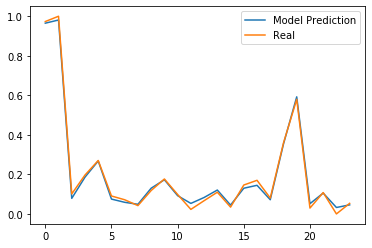

predicted =  [0.9649585]        real =  0.973256924546323       
predicted =  [0.98096126]        real =  1.0       
predicted =  [0.07874926]        real =  0.10124164278892073       
predicted =  [0.18598516]        real =  0.1967526265520535       
predicted =  [0.2678589]        real =  0.2702960840496657       
predicted =  [0.07501638]        real =  0.09073543457497614       
predicted =  [0.05871351]        real =  0.07163323782234958       
predicted =  [0.0486687]        real =  0.04202483285577842       
predicted =  [0.13003907]        real =  0.11843361986628465       
predicted =  [0.17281188]        real =  0.1766953199617956       
predicted =  [0.09232908]        real =  0.09837631327602676       
predicted =  [0.05320086]        real =  0.022922636103151865       
predicted =  [0.08308747]        real =  0.06685768863419295       
predicted =  [0.12078373]        real =  0.10983763132760269       
predicted =  [0.0446877]        real =  0.03438395415472779       
pred

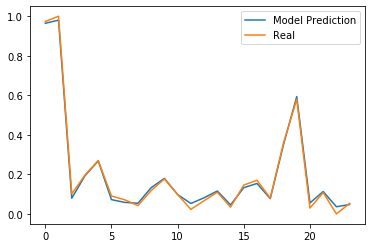

predicted =  [0.96445924]        real =  0.973256924546323       
predicted =  [0.9801027]        real =  1.0       
predicted =  [0.07936605]        real =  0.10124164278892073       
predicted =  [0.19318306]        real =  0.1967526265520535       
predicted =  [0.26802415]        real =  0.2702960840496657       
predicted =  [0.07222462]        real =  0.09073543457497614       
predicted =  [0.05838253]        real =  0.07163323782234958       
predicted =  [0.05381136]        real =  0.04202483285577842       
predicted =  [0.13277705]        real =  0.11843361986628465       
predicted =  [0.1797281]        real =  0.1766953199617956       
predicted =  [0.09808346]        real =  0.09837631327602676       
predicted =  [0.05281839]        real =  0.022922636103151865       
predicted =  [0.08168117]        real =  0.06685768863419295       
predicted =  [0.11594312]        real =  0.10983763132760269       
predicted =  [0.04563088]        real =  0.03438395415472779       
pr

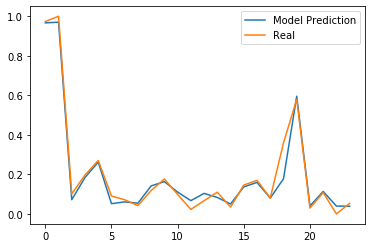

predicted =  [0.966561]        real =  0.973256924546323       
predicted =  [0.96988344]        real =  1.0       
predicted =  [0.07195134]        real =  0.10124164278892073       
predicted =  [0.1841487]        real =  0.1967526265520535       
predicted =  [0.26220113]        real =  0.2702960840496657       
predicted =  [0.05183372]        real =  0.09073543457497614       
predicted =  [0.0608124]        real =  0.07163323782234958       
predicted =  [0.05435912]        real =  0.04202483285577842       
predicted =  [0.14173967]        real =  0.11843361986628465       
predicted =  [0.163332]        real =  0.1766953199617956       
predicted =  [0.11047789]        real =  0.09837631327602676       
predicted =  [0.06718808]        real =  0.022922636103151865       
predicted =  [0.10386774]        real =  0.06685768863419295       
predicted =  [0.08327632]        real =  0.10983763132760269       
predicted =  [0.05024883]        real =  0.03438395415472779       
predic

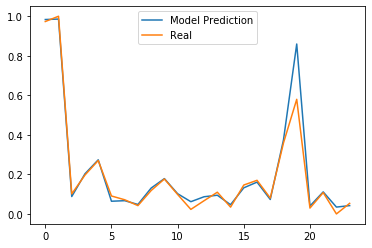

predicted =  [0.98338705]        real =  0.973256924546323       
predicted =  [0.9858013]        real =  1.0       
predicted =  [0.08799463]        real =  0.10124164278892073       
predicted =  [0.20310223]        real =  0.1967526265520535       
predicted =  [0.27372244]        real =  0.2702960840496657       
predicted =  [0.06412836]        real =  0.09073543457497614       
predicted =  [0.06694089]        real =  0.07163323782234958       
predicted =  [0.04777335]        real =  0.04202483285577842       
predicted =  [0.13081704]        real =  0.11843361986628465       
predicted =  [0.17854567]        real =  0.1766953199617956       
predicted =  [0.10218541]        real =  0.09837631327602676       
predicted =  [0.06183657]        real =  0.022922636103151865       
predicted =  [0.08687167]        real =  0.06685768863419295       
predicted =  [0.09456886]        real =  0.10983763132760269       
predicted =  [0.04661173]        real =  0.03438395415472779       
p

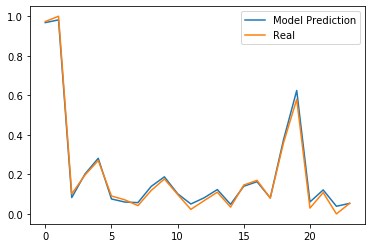

predicted =  [0.96771985]        real =  0.973256924546323       
predicted =  [0.9815745]        real =  1.0       
predicted =  [0.08279233]        real =  0.10124164278892073       
predicted =  [0.20186338]        real =  0.1967526265520535       
predicted =  [0.2813826]        real =  0.2702960840496657       
predicted =  [0.07563166]        real =  0.09073543457497614       
predicted =  [0.06016613]        real =  0.07163323782234958       
predicted =  [0.05711796]        real =  0.04202483285577842       
predicted =  [0.1390483]        real =  0.11843361986628465       
predicted =  [0.18755779]        real =  0.1766953199617956       
predicted =  [0.10211555]        real =  0.09837631327602676       
predicted =  [0.05022007]        real =  0.022922636103151865       
predicted =  [0.08132784]        real =  0.06685768863419295       
predicted =  [0.12313046]        real =  0.10983763132760269       
predicted =  [0.04849584]        real =  0.03438395415472779       
pre

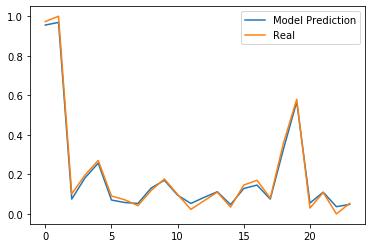

predicted =  [0.95538753]        real =  0.973256924546323       
predicted =  [0.96886015]        real =  1.0       
predicted =  [0.075189]        real =  0.10124164278892073       
predicted =  [0.18237069]        real =  0.1967526265520535       
predicted =  [0.256898]        real =  0.2702960840496657       
predicted =  [0.07019964]        real =  0.09073543457497614       
predicted =  [0.05772515]        real =  0.07163323782234958       
predicted =  [0.05277744]        real =  0.04202483285577842       
predicted =  [0.13081041]        real =  0.11843361986628465       
predicted =  [0.17021425]        real =  0.1766953199617956       
predicted =  [0.0946464]        real =  0.09837631327602676       
predicted =  [0.05284565]        real =  0.022922636103151865       
predicted =  [0.08371861]        real =  0.06685768863419295       
predicted =  [0.11204921]        real =  0.10983763132760269       
predicted =  [0.04707004]        real =  0.03438395415472779       
predi

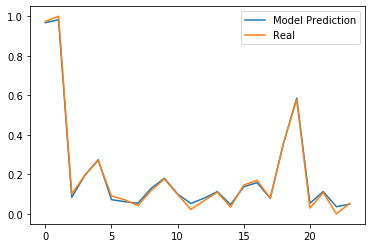

predicted =  [0.96762073]        real =  0.973256924546323       
predicted =  [0.982205]        real =  1.0       
predicted =  [0.08425368]        real =  0.10124164278892073       
predicted =  [0.19676697]        real =  0.1967526265520535       
predicted =  [0.27409026]        real =  0.2702960840496657       
predicted =  [0.07211999]        real =  0.09073543457497614       
predicted =  [0.06218642]        real =  0.07163323782234958       
predicted =  [0.05382248]        real =  0.04202483285577842       
predicted =  [0.1294256]        real =  0.11843361986628465       
predicted =  [0.1804034]        real =  0.1766953199617956       
predicted =  [0.10025438]        real =  0.09837631327602676       
predicted =  [0.05291843]        real =  0.022922636103151865       
predicted =  [0.07945478]        real =  0.06685768863419295       
predicted =  [0.11279766]        real =  0.10983763132760269       
predicted =  [0.04705565]        real =  0.03438395415472779       
pred

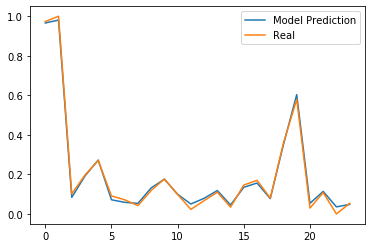

predicted =  [0.96588916]        real =  0.973256924546323       
predicted =  [0.98064154]        real =  1.0       
predicted =  [0.08383961]        real =  0.10124164278892073       
predicted =  [0.19207714]        real =  0.1967526265520535       
predicted =  [0.27266625]        real =  0.2702960840496657       
predicted =  [0.07148325]        real =  0.09073543457497614       
predicted =  [0.05869846]        real =  0.07163323782234958       
predicted =  [0.05321631]        real =  0.04202483285577842       
predicted =  [0.13152829]        real =  0.11843361986628465       
predicted =  [0.17568548]        real =  0.1766953199617956       
predicted =  [0.09916236]        real =  0.09837631327602676       
predicted =  [0.05010895]        real =  0.022922636103151865       
predicted =  [0.07886463]        real =  0.06685768863419295       
predicted =  [0.11824604]        real =  0.10983763132760269       
predicted =  [0.04502206]        real =  0.03438395415472779       


In [13]:
all_test_y = []
all_test_predication = []
avg_ame = 0
print("training using 24 folds: each model has 200 epochs")
start  = time.time()
for i in range(1):
    for i in range(24):
        print(" ")
        print("Fold ","#",i+1)
        
        model = Sequential()
        model.add(Dense((128), activation="tanh", input_shape=(7,)))
        model.add(Dense((64), activation="tanh"))
        model.add(Dense((32), activation="tanh"))
        model.add(Dense((1), activation="sigmoid"))
        model.compile(loss="mean_squared_error", optimizer="Adam", metrics=["mae","mape"])
        
        train_data, test_data = trainTestSpliter(foldsIndex[i],scaled_data)
        train_x, train_y, test_x, test_y = dataTargetSpluter(train_data,test_data)
        model.fit(train_x,train_y, epochs=200, batch_size=10, verbose=0, validation_data=(test_x,test_y))
        
        all_data_x =[]
        all_data_y = []
        for i in scaled_data:
            all_data_x.append(i[:len(i)])
            all_data_y.append(i[len(i)-1])
        all_data_x = np.array(all_data_x)
        all_data_y = np.array(all_data_y)
        prediction = model.predict(all_data_x)
        
        plt.plot(prediction, label="Model Prediction")
        plt.plot(all_data_y, label="Real")
        plt.legend()
        plt.show()
        
        for i in range(len(prediction)):
            print("predicted = ", prediction[i],"      ","real = ", all_data_y[i],"      ")
        print("All-data-MAE: ",mean_absolute_error(all_data_y,prediction))
    
        prediction = model.predict(test_x)
        print("Test-MAE: ",mean_absolute_error(test_y,prediction))
        all_test_y.append(test_y)
        all_test_predication.append(prediction)
        avg_ame+=mean_absolute_error(test_y,prediction)
        end = time.time()
        print("Fold Took: ",end-start)
        print("#################################################################################################")
print("\n \n avg test-MAE : ",avg_ame/24)

In [14]:
import statistics 
maes=[]
pred_25 = []
pred_50 = []
div=0
for i in range(len(all_test_y)):
    #print((abs(all_test_y[i]-all_test_predication[i])/all_test_y[i]))
    if all_test_y[i]==0.:
        div+=1
    else:
        maes.append((abs(all_test_y[i]-all_test_predication[i])/all_test_y[i]))
        if (abs(all_test_y[i]-all_test_predication[i])/all_test_y[i])<0.25:
            pred_25.append(abs(all_test_y[i]-all_test_predication[i])/all_test_y[i])
        if (abs(all_test_y[i]-all_test_predication[i])/all_test_y[i])<0.50:
            pred_50.append(abs(all_test_y[i]-all_test_predication[i])/all_test_y[i])
sum = 0
for i in maes:
    sum+=i
print("MMRE", sum/(len(maes)-div))
print("PRED 0.25: ", (((100/24)*(len(pred_25)-div)))/100)
print("PRED 0.50: ", (((100/24)*(len(pred_50)-div)))/100)
print("Median: ",statistics.median(maes))

MMRE [[0.30782966]]
PRED 0.25:  0.5416666666666667
PRED 0.50:  0.7916666666666667
Median:  [[0.21504539]]
